Command file to process data for CSV file - Scotlands Heat Map and deriving projected budget allocation for insulating dundee (https://www.data.gov.uk/dataset/cd74dd0e-286f-41b4-86dc-890b9fe0adb8/heat-demand-of-properties-by-data-zone-scotland?utm_source=chatgpt.com)

In [1]:
#importing library 
import pandas as pd

#importing the data
data = pd.read_csv('/Users/ericmarshall/Desktop/data visualisation compeition /Source data DO NOT EDIT/Datazone_Heat_Demand.csv')
# removing emplty columns 
Scotland_Heatmap = data.iloc[:, :5]
#renaming column to create join key
Scotland_Heatmap.rename(columns={'Datazone2011':'small_area'}, inplace=True) 

#Creating heatmap per capita dataset by merging heatmap with population dataset 

#import population data
Population_Data = pd.read_excel('/Users/ericmarshall/Desktop/data visualisation compeition /Source data DO NOT EDIT/Populationdata.xlsx', sheet_name='Persons', skiprows=3)

#renaming column to get join key
Population_Data = Population_Data.rename(
    columns={'Data zone code': 'small_area'}
)
Population_Data

# selecting poluation data column and join key 
Population_Data = Population_Data.iloc[:, [0, 4]]
Population_Data

#join data 
Heatmap_with_Population = pd.merge(Scotland_Heatmap, Population_Data, on='small_area')


# dividing heat demand in data zone by the population of the data zone to get per capita heat demand
Heatmap_with_Population["Demand_Per_Capita_kwh/pop"] = (
    Heatmap_with_Population["TotalHeatDemand_kwh_y"] /
    Heatmap_with_Population["Total population"]
)

#exporting final heatmap with population data and per capita heat demand column
Heatmap_with_Population.to_csv('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Heatmap_with_Population.csv', index=False)

Data = pd.read_csv('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Heatmap_with_Population.csv')

#removing crazy outliers from the dataset that would skew the budget allocation and are also almost certainly incorrect 
Data = Data[Data["Demand_Per_Capita_kwh/pop"] < 50_000]
Data = Data[Data["TotalHeatDemand_kwh_y"] < 100_000_000]

#reordering rows by row number 
Data = Data.reset_index(drop=True)

# getting mean heat demand per capita 
Data['mean_heat_demand_percap'] = Data['Demand_Per_Capita_kwh/pop'].sum() / 6974


# deriving heating inefficinecy indext to allocate budget proportionately to heat demand 
Data['heating_inefficieny_index'] = Data['Demand_Per_Capita_kwh/pop'] / Data['mean_heat_demand_percap'] 

#calculation weight for budget allocation (Total annual demand x Heating inefficiency index)
Data['budget_allocation_weight'] = Data['TotalHeatDemand_kwh_y'] * Data['heating_inefficieny_index']

#calculation scotland insulation budget 
#total heat budget for scotland is derived by uk budget / uk population * scottish population
total_budget = 40_200_000 / 69_771_298 * 5_560_000 # = 3203494.938563419


#budget allocation based on weights 
Data['Predicted_insulation_spend'] = (Data['budget_allocation_weight'] / Data['budget_allocation_weight'].sum()) * total_budget

#selecting predicted spend and join key 
Data_Frame = Data[['Predicted_insulation_spend', 'small_area']]

Data_Frame.to_csv('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Predicted_Insulation_Spend_Scotland')
# importing lookup table 
Lookup_Table = pd.read_excel('/Users/ericmarshall/Desktop/data visualisation compeition /Source data DO NOT EDIT/lookups.xlsx')

# removing unnecessary columns
Lookup_Table = Lookup_Table.iloc[:, [0, 3]]
Dundee_Datazones = Lookup_Table.loc[Lookup_Table['local_authority'] == 'Dundee City']
# keeping only small_area as join key and name of local authority to get data zone codes for dundee city 

Dundee_Datazones.to_csv('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Dundee_Datazones.csv', index=False)

#merging predicted spend with dundee datazones to get only the predicted spend for dundee localities 
Dundee_Predicted_Spend = Data_Frame.merge(Dundee_Datazones, on='small_area', how='inner')

Dundee_Predicted_Spend.to_csv('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Dunee_Predicted_Spend.csv')




Selecting dundee geometry 

/var/folders/xh/120rhvzs2vjg8p4fsk_11tkh0000gn/T/ipykernel_59217/2520314477.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  Dundee_Shp.to_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Dundee_Shp.shp')
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'local_authority' to 'local_auth'
  ogr_write(


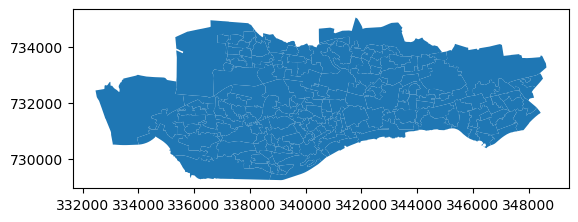

In [2]:
#importing relevant libraries 
import geopandas as gpd 

#importing shapefile
shp = gpd.read_file('/Users/ericmarshall/Desktop/data visualisation compeition /Source data DO NOT EDIT/Small_areas.shp ')


#selecting scotland cases using fancy indexing 
scotland = shp[shp['small_area'].str.startswith('S')]
scotland.to_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Scotland_Small_Areas.shp')

# extracting Dundee Datazones 
Lookup = gpd.read_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Dundee_Datazones.csv')
Dundee_Shp = scotland.merge(Lookup, on='small_area', how='inner')
Dundee_Shp.plot()
# seeing len to see how many (should be 188)
len(Dundee_Shp)
#saving file 
Dundee_Shp.to_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Dundee_Shp.shp')


In [3]:
Co_Ben = gpd.read_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/CSV data for visualisation /Dundee_Co_Benefits.csv')
Pre_Spend = gpd.read_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/CSV data for visualisation /Dunee_Predicted_Spend.csv')
ShapeFile = gpd.read_file('/Users/ericmarshall/Desktop/data visualisation compeition /Edited datasets/Dundee SHP/Dundee_Shp.shp')

In [4]:
# resetting header 
Co_Ben.columns = Co_Ben.iloc[0]
Co_Ben = Co_Ben.iloc[1:].reset_index(drop=True)

# removing unecessary column 
Pre_Spend = Pre_Spend.iloc[:, 1:]
#merging datasets 
DATA = ShapeFile.merge(Co_Ben, left_on='small_area', right_on='small_area').merge(Pre_Spend, left_on='small_area', right_on='small_area')
# removing duplicate columns
Data = DATA.drop(columns=[DATA.columns[1], DATA.columns[2], DATA.columns[32], DATA.columns[34]])
Data = Data.drop(columns=['co-benefit_type', Data.columns[1]])
#renaming columns to standardise naming 
Data.rename(columns={'Predicted_insulation_spend': 'ins_spend'}, inplace=True)
Data.rename(columns={'sum': 'sum_co_benefits'}, inplace=True)

#adding geometry to the dataset 
map_gpd = ShapeFile.merge(Data, left_on='small_area', right_on='small_area', how='left')
map_gpd.drop(columns=[map_gpd.columns[1]], inplace=True)

In [11]:
# Interactive time-series map (2025–2050) + ONE combined totals bar chart (Spent + Benefits)
# - Map colour: Δ cumulative co-benefits vs 2025 (per zone), in THOUSANDS
# - Total spent: (sum of predicted spend / #years) accumulated year-by-year, shown in £k
# - Total benefits: sequential cumulative sum of yearly benefits, shown in "k"
# - Slider 2025–2050 + icon-only ▶ (play) and ⏹ (stop/reset) buttons
#
# NOTE: This version avoids Python's built-in max() entirely (fixes the "'float' object is not callable" issue).

import numpy as np
import pandas as pd
import geopandas as gpd
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -------------------------
# INPUTS / SETUP
# -------------------------
gdf = map_gpd.copy()

start_year = 2025
end_year   = 2050
year_cols = list(map(str, range(start_year, end_year + 1)))
n_years = len(year_cols)  # 26 inclusive

# Change if your spend column has a different name:
SPEND_COL = "ins_spend"

# Your benefit values are in MILLIONS (e.g. 1.1 == 1.1 million).
# Convert annual benefits to THOUSANDS by multiplying by 1000.
BENEFIT_MILLIONS_TO_THOUSANDS = 1000.0

# -------------------------
# 1) Fix dtypes (object -> numeric) + unit conversion
# -------------------------
gdf[year_cols] = gdf[year_cols].apply(lambda s: pd.to_numeric(s, errors="coerce")).fillna(0.0)
gdf[year_cols] = gdf[year_cols] * BENEFIT_MILLIONS_TO_THOUSANDS

gdf[SPEND_COL] = pd.to_numeric(gdf[SPEND_COL], errors="coerce").fillna(0.0)

# -------------------------
# 2) Cumulative benefits per zone, and delta vs 2025 for colouring
# -------------------------
cum_benefit_cols = [f"cum_benefit_{y}" for y in year_cols]
gdf[cum_benefit_cols] = gdf[year_cols].cumsum(axis=1)

gdf["baseline_2025"] = gdf[f"cum_benefit_{start_year}"]
for y in year_cols:
    gdf[f"delta_vs_2025_{y}"] = gdf[f"cum_benefit_{y}"] - gdf["baseline_2025"]

# -------------------------
# 3) Spend: annual = total / years, then cumulative per year
# -------------------------
gdf["annual_spend"] = gdf[SPEND_COL] / n_years
for i, y in enumerate(year_cols, start=1):
    gdf[f"cum_spend_{y}"] = gdf["annual_spend"] * i

# -------------------------
# 4) Long table for animation
# -------------------------
records = []
for y in year_cols:
    tmp = gdf[["small_area", "geometry"]].copy()
    tmp["year"] = int(y)

    # benefits are in THOUSANDS now
    tmp["cum_benefit_k"] = gdf[f"cum_benefit_{y}"].values
    tmp["delta_benefit_k"] = gdf[f"delta_vs_2025_{y}"].values

    # spend is still in currency units here (we convert totals to k later)
    tmp["cum_spend"] = gdf[f"cum_spend_{y}"].values
    records.append(tmp)

long = pd.concat(records, ignore_index=True)
long = gpd.GeoDataFrame(long, geometry="geometry", crs=getattr(gdf, "crs", None))

# CRS for web maps (Mapbox expects EPSG:4326)
if long.crs is not None:
    long = long.to_crs(4326)
# If CRS missing but you know it's EPSG:27700:
# long = long.set_crs(27700, allow_override=True).to_crs(4326)

# -------------------------
# 5) Totals per year (sum across zones), convert to THOUSANDS
# -------------------------
totals = (
    long.groupby("year", as_index=False)
        .agg(
            total_spent=("cum_spend", "sum"),
            total_benefits_k=("cum_benefit_k", "sum"),   # already in thousands
        )
)

totals["total_spent_k"] = totals["total_spent"] / 1_000  # £ -> £k

# Shared y-axis max (avoid built-in max())
ymax = float(totals[["total_spent_k", "total_benefits_k"]].max().max()) * 1.12

# Map colour range
cmin = long["delta_benefit_k"].min()
cmax = long["delta_benefit_k"].max()

# GeoJSON for map
geojson = json.loads(long[["small_area", "geometry"]].drop_duplicates().to_json())

# -------------------------
# 6) Layout: Map + ONE combined bar chart
# -------------------------
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "mapbox"}, {"type": "bar"}]],
    column_widths=[0.70, 0.30],
    horizontal_spacing=0.06,
    subplot_titles=[
        "Cumulative Healthcare Savings from Dampness Reduction in Homes",
        "Total (in thousands)"
    ]
)

year0 = int(totals["year"].min())

map0 = long[long["year"] == year0]
t0 = totals[totals["year"] == year0].iloc[0]

# Map trace
fig.add_trace(
    go.Choroplethmapbox(
        geojson=geojson,
        locations=map0["small_area"],
        z=map0["delta_benefit_k"],
        featureidkey="properties.small_area",
        colorscale="Plasma",
        zmin=cmin, zmax=cmax,
        marker_opacity=0.75,
        marker_line_width=0.2,
        colorbar_title="Sum of Savings (in thousands)"
    ),
    row=1, col=1
)

# Combined bar chart: spent + benefits on SAME axis
fig.add_trace(
    go.Bar(
        x=["Investment", "Healthcare Savings"],
        y=[t0["total_spent_k"], t0["total_benefits_k"]],
        text=[f"{t0['total_spent_k']:,.1f}", f"{t0['total_benefits_k']:,.1f}"],
        textposition="outside",
        marker_line_width=0,
        showlegend=False,
        marker=dict(color=['red', 'green'])
        
    ),
    row=1, col=2
)
fig.update_yaxes(range=[0, ymax], row=1, col=2)

# -------------------------
# 7) Frames: update map + combined bar chart
# -------------------------
frames = []
years_int = totals["year"].astype(int).tolist()

for y in years_int:
    map_y = long[long["year"] == y]
    ty = totals[totals["year"] == y].iloc[0]

    frames.append(
        go.Frame(
            name=str(y),
            data=[
                go.Choroplethmapbox(
                    locations=map_y["small_area"],
                    z=map_y["delta_benefit_k"]
                ),
                go.Bar(
                    y=[ty["total_spent_k"], ty["total_benefits_k"]],
                    text=[f"{ty['total_spent_k']:,.1f}", f"{ty['total_benefits_k']:,.1f}"]
                ),
            ]
        )
    )

fig.frames = frames

# Slider steps
steps = [{
    "method": "animate",
    "label": str(y),
    "args": [[str(y)], {"mode": "immediate", "frame": {"duration": 350, "redraw": True}, "transition": {"duration": 0}}]
} for y in years_int]

# -------------------------
# 8) Icon-only ▶ Play and ⏹ Stop/Reset buttons + slider
# -------------------------
fig.update_layout(
    updatemenus=[{
        "type": "buttons",
        "direction": "left",
        "x": 0.02,
        "y": -0.12,
        "xanchor": "left",
        "yanchor": "top",
        "pad": {"r": 6, "t": 6},
        "showactive": False,
        "buttons": [
            # ▶ PLAY
            {
                "label": "▶",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 500, "redraw": True},
                        "transition": {"duration": 0},
                        "fromcurrent": True,
                        "mode": "immediate"
                    }
                ]
            },
            # ⏹ STOP (reset to first year)
            {
                "label": "⏹",
                "method": "animate",
                "args": [
                    [[str(year0)]],
                    {
                        "frame": {"duration": 0, "redraw": True},
                        "transition": {"duration": 0},
                        "mode": "immediate"
                    }
                ]
            }
        ]
    }],
    sliders=[{
        "steps": steps,
        "currentvalue": {"prefix": "Year: "},
        "x": 0.18,
        "y": -0.13,
        "len": 0.80,
        "pad": {"t": 0, "b": 0}
    }]
)




# -------------------------
# 9) Map view + margins + title
# -------------------------
center = long.geometry.unary_union.centroid
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": center.y, "lon": center.x},
    mapbox_zoom=10,
    margin={"r": 10, "t": 80, "l": 10, "b": 130},
    title="Dundee – Healthcare Savings and Energy Efficiency Investment 2025–2050"
)

fig.show()

# Optional save:
# fig.write_html("dundee_timeseries_map_combined_bars_icons.html")


/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

In [12]:
 fig.write_html(
    "/Users/ericmarshall/Desktop/data visualisation compeition / dundee_timeseries_map_2025_2050_offline.html",
    include_plotlyjs=True
)
